# week9_RS_basic - 19기 김은지

1. 파이썬을 이용하여 무지렌즈 데이터(ml-latest-small)를 전처리 및 EDA 진행해주세요.
    - 유의미한 분석 5개 이상
2. Memory based CF 2개 이상, Model based CF 2개 이상 알고리즘을 사용해서 아래 결과를 출력해주세요.
    - 성능 평가
    - 추천 결과 출력
  + Suprise library 사용 가능

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

# 마이너스 기호 출력
plt.rc('axes', unicode_minus=False)

In [3]:
# 경로 고정
%cd C:/Users/User/Downloads/ml-latest-small/ml-latest-small

C:\Users\User\Downloads\ml-latest-small\ml-latest-small


# 1. 데이터 확인
해당 데이터는 MovieLens Latest Datasets로 small version은 600명의 사용자와 9000개의 영화 정보가 제공된다. 

In [145]:
links = pd.read_csv('links.csv', index_col = 'movieId')
movies = pd.read_csv('movies.csv', index_col = 'movieId')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')

#### links.csv
각 영화의 아이디가 인덱스로 할당되어 있음.

In [5]:
links

,imdbId,tmdbId
movieId,,
1,114709,862.0
2,113497,8844.0
3,113228,15602.0
4,114885,31357.0
5,113041,11862.0
...,...,...
193581,5476944,432131.0
193583,5914996,445030.0
193585,6397426,479308.0


#### movie.csv
영화 정보가 담긴 데이터
각 영화의 아이디가 인덱스로 할당되어 있고, 칼럼으로 title(영화제목)과 genres(장르)를 가지고 있다.

In [6]:
movies

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
...,...,...
193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
193585,Flint (2017),Drama


#### ratings.csv
사용자마다 관람한 영화에 대해 평점을 남긴 데이터
사용자 한 명이 관람한 모든 영화에 대한 정보가 저장되어 있다.

In [7]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


#### tags.csv
사용자가 영화를 관람한 후 남긴 리뷰로부터 추출된 태그가 저장된 데이터
태그는 자연어(영어)로 이루어져있으며 어떤 속성의 태그들이 많이 포함되어 있는지를 분석할 수 있다.

In [8]:
tags

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


# 2. EDA

In [69]:
# movies.csv에서 title 연도만 뽑아서 year 변수 만들기
movies['year'] = movies['title'].str.extract('(\(\d\d\d\d\))') 
movies['year'] = movies['year'].apply(lambda x: str(x).replace('(','').replace(')',''))
movies.head()

,title,genres,year
movieId,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
2,Jumanji (1995),Adventure|Children|Fantasy,1995
3,Grumpier Old Men (1995),Comedy|Romance,1995
4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
5,Father of the Bride Part II (1995),Comedy,1995


In [45]:
genres_df = movies['genres'].str.get_dummies(sep='|')
genres_df.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [46]:
movies['year']

movieId
1         1995
2         1995
3         1995
4         1995
5         1995
          ... 
193581    2017
193583    2017
193585    2017
193587    2018
193609    1991
Name: year, Length: 9742, dtype: object

In [47]:
movies['year'].values

array(['1995', '1995', '1995', ..., '2017', '2018', '1991'], dtype=object)

In [48]:
vc_year

2002    311
2006    295
2001    294
2007    284
2000    283
       ... 
1922      1
1915      1
1917      1
1903      1
1902      1
Name: year, Length: 107, dtype: int64

In [49]:
movies = pd.DataFrame(movies)
movies

,title,genres,year
movieId,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
2,Jumanji (1995),Adventure|Children|Fantasy,1995
3,Grumpier Old Men (1995),Comedy|Romance,1995
4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
5,Father of the Bride Part II (1995),Comedy,1995
...,...,...,...
193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,2017
193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,2017
193585,Flint (2017),Drama,2017


In [50]:
movies['year'].value_counts

<bound method IndexOpsMixin.value_counts of movieId
1         1995
2         1995
3         1995
4         1995
5         1995
          ... 
193581    2017
193583    2017
193585    2017
193587    2018
193609    1991
Name: year, Length: 9742, dtype: object>

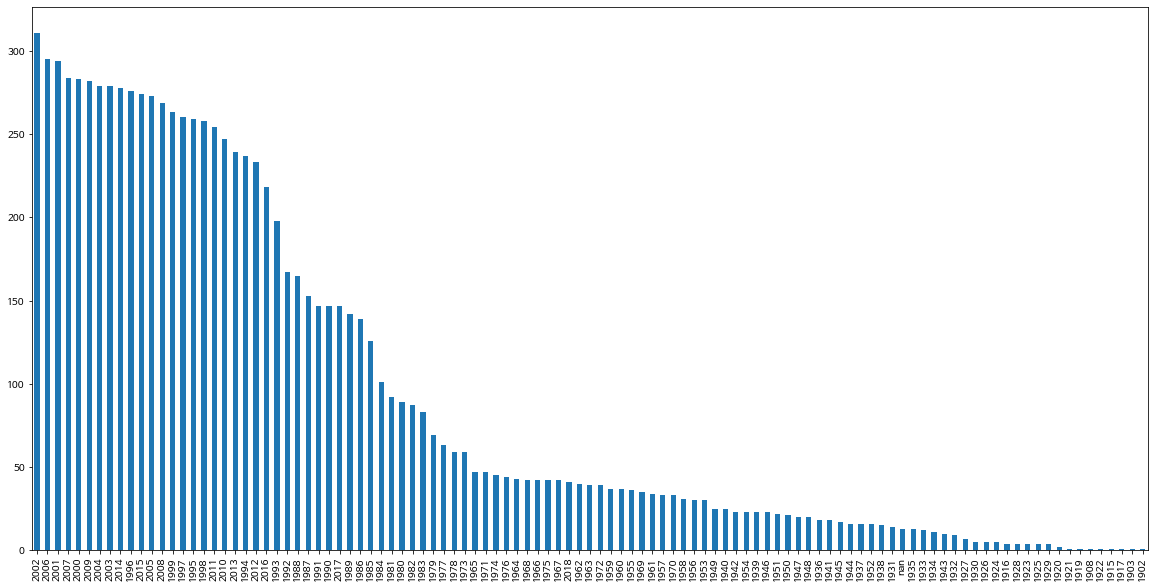

In [51]:
plt.figure(figsize=(20,10))
vc_year = movies['year'].value_counts()
vc_year.plot.bar()

10년 단위로 파악

In [70]:
movies['year'] = pd.to_numeric(movies['year'], errors='coerce')
#movies.info()

In [71]:
movies.dropna(inplace=True)

In [72]:
movies['years'] = movies['year'] //10 * 10
movies['years']

movieId
1         1990
2         1990
3         1990
4         1990
5         1990
          ... 
193581    2010
193583    2010
193585    2010
193587    2010
193609    1990
Name: years, Length: 9729, dtype: int64

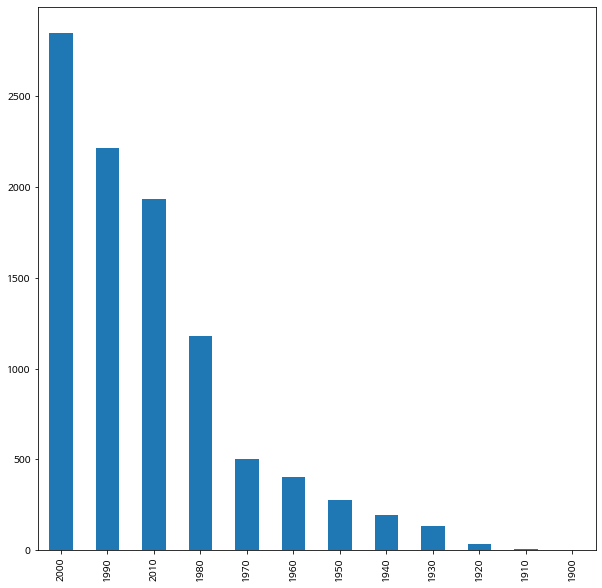

In [74]:
plt.figure(figsize=(10,10))
vc_year = movies['years'].value_counts()
vc_year.plot.bar()

2000년대, 1990년대, 2010년대 순으로 데이터가 많았다.

In [76]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [78]:
list(ratings['movieId'].unique())

[1,
 3,
 6,
 47,
 50,
 70,
 101,
 110,
 151,
 157,
 163,
 216,
 223,
 231,
 235,
 260,
 296,
 316,
 333,
 349,
 356,
 362,
 367,
 423,
 441,
 457,
 480,
 500,
 527,
 543,
 552,
 553,
 590,
 592,
 593,
 596,
 608,
 648,
 661,
 673,
 733,
 736,
 780,
 804,
 919,
 923,
 940,
 943,
 954,
 1009,
 1023,
 1024,
 1025,
 1029,
 1030,
 1031,
 1032,
 1042,
 1049,
 1060,
 1073,
 1080,
 1089,
 1090,
 1092,
 1097,
 1127,
 1136,
 1196,
 1197,
 1198,
 1206,
 1208,
 1210,
 1213,
 1214,
 1219,
 1220,
 1222,
 1224,
 1226,
 1240,
 1256,
 1258,
 1265,
 1270,
 1275,
 1278,
 1282,
 1291,
 1298,
 1348,
 1377,
 1396,
 1408,
 1445,
 1473,
 1500,
 1517,
 1552,
 1573,
 1580,
 1587,
 1617,
 1620,
 1625,
 1644,
 1676,
 1732,
 1777,
 1793,
 1804,
 1805,
 1920,
 1927,
 1954,
 1967,
 2000,
 2005,
 2012,
 2018,
 2028,
 2033,
 2046,
 2048,
 2054,
 2058,
 2078,
 2090,
 2093,
 2094,
 2096,
 2099,
 2105,
 2115,
 2116,
 2137,
 2139,
 2141,
 2143,
 2161,
 2174,
 2193,
 2253,
 2268,
 2273,
 2291,
 2329,
 2338,
 2353,
 2366,
 

In [82]:
mid = 1
list(ratings[ratings['movieId']==mid]['rating'].values)

[4.0,
 4.0,
 4.5,
 2.5,
 4.5,
 3.5,
 4.0,
 3.5,
 3.0,
 5.0,
 3.0,
 3.0,
 5.0,
 5.0,
 3.0,
 4.0,
 5.0,
 3.0,
 3.0,
 5.0,
 5.0,
 4.0,
 4.0,
 2.5,
 5.0,
 4.5,
 0.5,
 4.0,
 2.5,
 4.0,
 3.0,
 3.0,
 4.0,
 3.0,
 5.0,
 4.5,
 4.0,
 4.0,
 3.0,
 3.5,
 4.0,
 4.0,
 3.0,
 2.0,
 3.0,
 4.0,
 4.0,
 3.0,
 4.0,
 3.5,
 5.0,
 5.0,
 2.0,
 3.0,
 4.0,
 4.5,
 4.0,
 4.0,
 5.0,
 3.5,
 4.5,
 5.0,
 5.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 2.0,
 3.5,
 5.0,
 4.0,
 5.0,
 3.5,
 3.0,
 3.0,
 4.0,
 3.5,
 5.0,
 3.5,
 3.5,
 5.0,
 3.5,
 3.0,
 5.0,
 4.0,
 5.0,
 5.0,
 4.0,
 4.5,
 4.5,
 4.0,
 4.0,
 2.0,
 5.0,
 5.0,
 5.0,
 4.0,
 5.0,
 4.0,
 4.0,
 3.0,
 4.5,
 4.5,
 3.0,
 4.5,
 4.0,
 4.0,
 4.0,
 3.0,
 2.0,
 5.0,
 4.0,
 3.0,
 3.5,
 3.5,
 5.0,
 4.0,
 4.0,
 3.5,
 4.0,
 4.0,
 4.0,
 5.0,
 5.0,
 4.0,
 5.0,
 5.0,
 4.0,
 5.0,
 5.0,
 3.0,
 3.0,
 4.5,
 5.0,
 3.5,
 4.5,
 4.0,
 5.0,
 3.0,
 5.0,
 4.0,
 3.5,
 5.0,
 2.0,
 4.0,
 4.0,
 4.0,
 2.5,
 4.0,
 4.0,
 4.5,
 4.0,
 5.0,
 5.0,
 5.0,
 5.0,
 4.5,
 1.5,
 4.0,
 4.0,
 4.0,
 5.0,
 4.0,
 4.0,
 4.0

In [106]:
import collections
uid_ratings = collections.defaultdict(int)
uid_ratings

defaultdict(int, {})

In [107]:
list(ratings['movieId'].unique())

[1,
 3,
 6,
 47,
 50,
 70,
 101,
 110,
 151,
 157,
 163,
 216,
 223,
 231,
 235,
 260,
 296,
 316,
 333,
 349,
 356,
 362,
 367,
 423,
 441,
 457,
 480,
 500,
 527,
 543,
 552,
 553,
 590,
 592,
 593,
 596,
 608,
 648,
 661,
 673,
 733,
 736,
 780,
 804,
 919,
 923,
 940,
 943,
 954,
 1009,
 1023,
 1024,
 1025,
 1029,
 1030,
 1031,
 1032,
 1042,
 1049,
 1060,
 1073,
 1080,
 1089,
 1090,
 1092,
 1097,
 1127,
 1136,
 1196,
 1197,
 1198,
 1206,
 1208,
 1210,
 1213,
 1214,
 1219,
 1220,
 1222,
 1224,
 1226,
 1240,
 1256,
 1258,
 1265,
 1270,
 1275,
 1278,
 1282,
 1291,
 1298,
 1348,
 1377,
 1396,
 1408,
 1445,
 1473,
 1500,
 1517,
 1552,
 1573,
 1580,
 1587,
 1617,
 1620,
 1625,
 1644,
 1676,
 1732,
 1777,
 1793,
 1804,
 1805,
 1920,
 1927,
 1954,
 1967,
 2000,
 2005,
 2012,
 2018,
 2028,
 2033,
 2046,
 2048,
 2054,
 2058,
 2078,
 2090,
 2093,
 2094,
 2096,
 2099,
 2105,
 2115,
 2116,
 2137,
 2139,
 2141,
 2143,
 2161,
 2174,
 2193,
 2253,
 2268,
 2273,
 2291,
 2329,
 2338,
 2353,
 2366,
 

In [111]:
# user별로 rating 통계량 확인
for mid in (list(ratings['movieId'].unique())):
    uid_ratings[mid] = round(np.mean(ratings[ratings['movieId']==mid]['rating'].values), 1)
uid_ratings

defaultdict(int,
            {1: 3.9,
             3: 3.3,
             6: 3.9,
             47: 4.0,
             50: 4.2,
             70: 3.5,
             101: 3.8,
             110: 4.0,
             151: 3.5,
             157: 2.9,
             163: 3.6,
             216: 3.3,
             223: 3.9,
             231: 3.1,
             235: 3.7,
             260: 4.2,
             296: 4.2,
             316: 3.4,
             333: 3.8,
             349: 3.6,
             356: 4.2,
             362: 3.5,
             367: 3.2,
             423: 2.8,
             441: 3.9,
             457: 4.0,
             480: 3.8,
             500: 3.4,
             527: 4.2,
             543: 3.3,
             552: 3.3,
             553: 3.8,
             590: 3.8,
             592: 3.4,
             593: 4.2,
             596: 3.4,
             608: 4.1,
             648: 3.5,
             661: 3.4,
             673: 2.7,
             733: 3.6,
             736: 3.3,
             780: 3.4,
   

Text(0.5, 1.0, 'userID별로 평균 평점 boxplot')

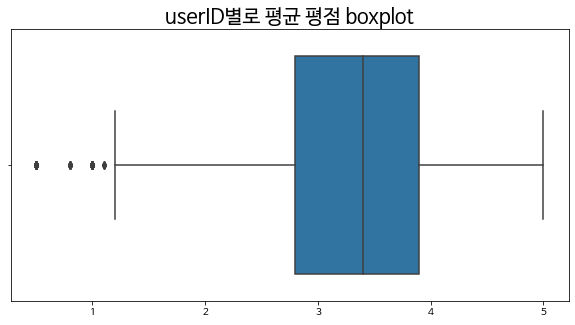

In [115]:
plt.figure(figsize=(10,5))
sns.boxplot(pd.DataFrame(uid_ratings.values()))
plt.title('userID별로 평균 평점 boxplot', fontsize=20)

In [133]:
genres_sum = pd.DataFrame(genres_df.sum(),columns={'sum'})
genres_sum.sort_values(by = 'sum', ascending=False,inplace=True)

Text(0.5, 1.0, '장르별 barplot')

<Figure size 1440x720 with 0 Axes>

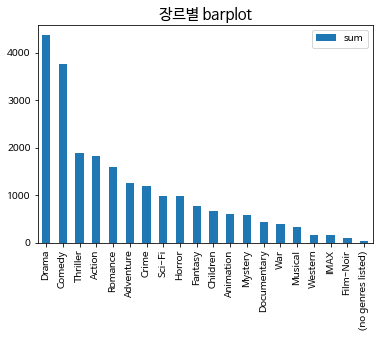

In [134]:
plt.figure(figsize=(20,10))
genres_sum.plot.bar()
plt.title('장르별 barplot', fontsize=15)

영화 장르를 리뷰가 많은 순으로 정렬했을 때 Drama, Comedy, Thriller, Action, Romance 순이었다. 

In [136]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [139]:
from wordcloud import WordCloud
from collections import Counter

In [146]:
tags['tag']

0                  funny
1        Highly quotable
2           will ferrell
3           Boxing story
4                    MMA
              ...       
3678           for katie
3679             austere
3680              gun fu
3681    heroic bloodshed
3682    Heroic Bloodshed
Name: tag, Length: 3683, dtype: object

In [158]:
# 가장 많이 나온 단어부터 40개를 저장한다.
counts = Counter(tags['tag'])
tags_100 = counts.most_common(100) 
tags_100

[('In Netflix queue', 131),
 ('atmospheric', 36),
 ('superhero', 24),
 ('thought-provoking', 24),
 ('funny', 23),
 ('Disney', 23),
 ('surreal', 23),
 ('religion', 22),
 ('sci-fi', 21),
 ('dark comedy', 21),
 ('quirky', 21),
 ('psychology', 21),
 ('suspense', 20),
 ('twist ending', 19),
 ('visually appealing', 19),
 ('crime', 19),
 ('politics', 18),
 ('music', 16),
 ('time travel', 16),
 ('mental illness', 16),
 ('dark', 15),
 ('comedy', 15),
 ('aliens', 15),
 ('space', 14),
 ('mindfuck', 14),
 ('dreamlike', 14),
 ('black comedy', 13),
 ('emotional', 13),
 ('heist', 13),
 ('anime', 12),
 ('action', 12),
 ('satire', 12),
 ('high school', 12),
 ('disturbing', 12),
 ('Shakespeare', 12),
 ('journalism', 12),
 ('Stephen King', 12),
 ('court', 12),
 ('imdb top 250', 11),
 ('comic book', 11),
 ('classic', 11),
 ('psychological', 11),
 ('Holocaust', 11),
 ('adolescence', 11),
 ('adultery', 11),
 ('boxing', 11),
 ('drugs', 10),
 ('Leonardo DiCaprio', 10),
 ('Mafia', 10),
 ('animation', 10),
 ('r

In [159]:
# WordCloud를 생성한다.
# 한글을 분석하기위해 font를 한글로 지정해주어야 된다. macOS는 .otf , window는 .ttf 파일의 위치를
# 지정해준다. (ex. '/Font/GodoM.otf')
wc = WordCloud(background_color="white", max_font_size=60)
cloud = wc.generate_from_frequencies(dict(tags_100))


# 생성된 WordCloud를 test.jpg로 보낸다.
cloud.to_file('test.jpg')

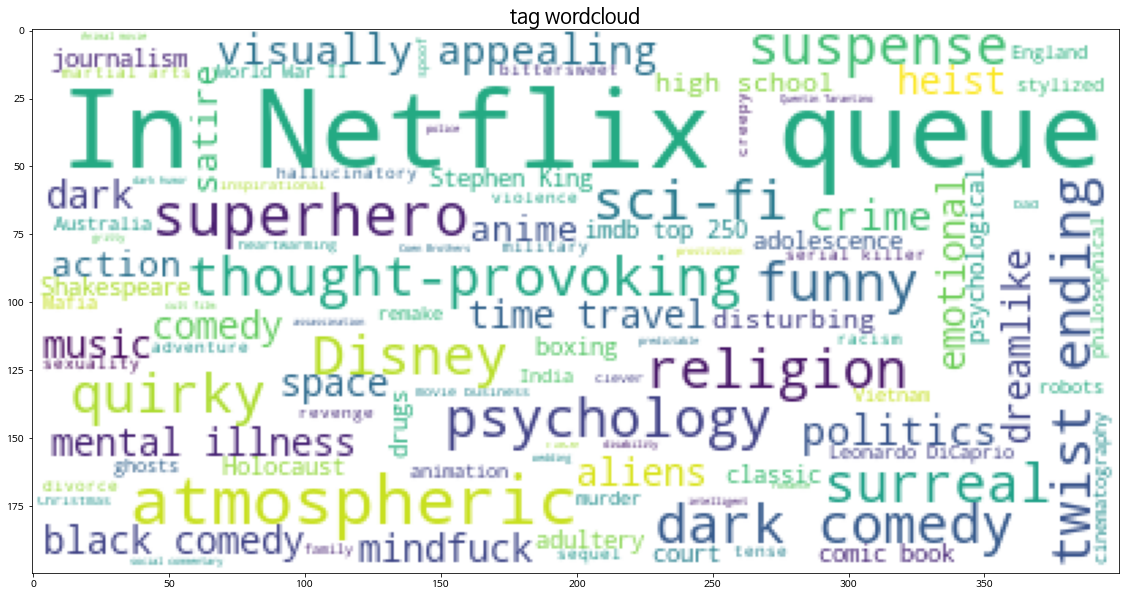

In [160]:
plt.figure(figsize=(20,10))
plt.imshow(wc)
plt.title('tag wordcloud', fontsize=20)
plt.show()

tag에서 빈도가 높은 상위 100개의 단어를 골라 wordcloud를 그려봤을 때, Netflix의 크기가 가장 큰 것으로 보아 해당 데이터는 넷플릭스를 통해 영화를 관람한 사용자가 다수임을 확인할 수 있고, Comedy가 상위 2번째 장르였는데, funny가 자주 출현한 단어여서 연관성이 있다고 판단하였다. 이와 유사하게 Thriller 장르도 상위 3번째 장르였는데, suspense단어가 자주 출현한 단어임을 확인할 수 있었다.

# 3. Memory based CF

# 4. Model based CF